# IBKR API

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import bt
from ib_insync import *
import nest_asyncio
import logging
import datetime
import schedule
import time

In [6]:
nest_asyncio.apply()

# Connect to TWS (or gateway)
ib = IB()

ib.connect('127.0.0.1', 7497, clientId=3) #7497 - Paper Trading, 7496 - Live trading

<IB connected to 127.0.0.1:7497 clientId=3>

In [7]:
#Define ES contract
contract = Future('ES', '202503', 'CME')

# Define the stock contract for AAPL
#contract = Stock('TSLA', 'SMART', 'USD')

# Qualify the contract (ensures IB recognizes it)
ib.qualifyContracts(contract)

[Future(conId=603558932, symbol='ES', lastTradeDateOrContractMonth='20250321', multiplier='50', exchange='CME', currency='USD', localSymbol='ESH5', tradingClass='ES')]

In [8]:
quote = ib.reqMktData(contract, "", False, False)

In [13]:
def printBid():
    print(quote.bid)

# Print initially and then every second
schedule.every(1).seconds.do(printBid)

while True:
    schedule.run_pending()
    time.sleep(0.5)

5978.5
5978.5
5978.5
5978.5
5978.5
5978.5
5978.5
5978.5
5978.5
5978.5
5978.5
5978.5
5978.5
5978.5
5978.5
5978.5


KeyboardInterrupt: 

In [177]:
# request live market data from ib
quote = ib.reqMktData(contract, "", False, False)

midpoint = (quote.ask + quote.bid)/2
midpoint = round(midpoint / 0.25) * 0.25

order = LimitOrder("Buy", 1, midpoint)

ib.placeOrder(contract, order)

ValueError: cannot convert float NaN to integer

In [296]:
# request live market data from ib
quote = ib.reqMktData(contract, "", False, False)

bid = quote.bid
my_bid = quote.bid + 0.01

order = LimitOrder("Buy", 1, my_bid)

ib.placeOrder(contract, order)
print("Order Sent")
print("Bid", quote.bid)

Order Sent
Bid 18.91


In [46]:
ib.disconnect()

In [89]:
# Fetch historical data
historical_data = ib.reqHistoricalData(
    contract,
    endDateTime='',          # Leave empty for the most recent data
    durationStr='1 D',       # Look back 1 month
    barSizeSetting='5 mins',  # Daily bars
    whatToShow='TRADES',     # Show trade data (other options: MIDPOINT, BID, ASK)
    useRTH=True              # Use Regular Trading Hours (RTH) only
)

In [90]:
# Convert the historical data to a pandas DataFrame
df = util.df(historical_data)

### Only do next step for intraday data:

In [91]:
# Set date column as index
df = df.set_index('date')
#convert to EST timezone
df.index = df.index.tz_convert('US/Eastern')

In [93]:
df.head()

,open,high,low,close,volume,average,barCount
date,,,,,,,
2025-02-24 09:30:00-05:00,6050.00,6060.00,6047.25,6051.00,39442.0,6053.000,13162
2025-02-24 09:35:00-05:00,6051.00,6051.75,6040.25,6042.25,33301.0,6045.125,11843
2025-02-24 09:40:00-05:00,6042.50,6045.50,6036.00,6040.25,31044.0,6040.975,10986
2025-02-24 09:45:00-05:00,6040.00,6043.00,6033.25,6035.75,26482.0,6038.475,8995
2025-02-24 09:50:00-05:00,6035.75,6036.00,6023.00,6025.75,34914.0,6029.075,10837


In [7]:
# Configure logging to record potential trades
logging.basicConfig(filename='paper_trades.log', level=logging.INFO)

In [8]:
def execute_seasonality_trade():
    today = datetime.datetime.now()
    target_days = [5]  # Example trade days
    trade_time = datetime.time(14, 49)  # Execute
    
    if today.day in target_days and today.time().hour == trade_time.hour and today.time().minute == trade_time.minute:
        trade_details = f"Paper Trade Log: {today.strftime('%Y-%m-%d %H:%M:%S')} - Buy ZO"
        print(trade_details)
        logging.info(trade_details)

        # Instead of placing an order, just log it
        return

    print("Not a trade day or time.")
    
# Test function
execute_seasonality_trade()

Not a trade day or time.


# Retrieve Front Month Contract

In [17]:
# Define generic MNQ contract
contract = Future(symbol="MNQ", exchange="CME")

# Request all available MNQ contracts
contracts = ib.reqContractDetails(contract)

# Print all available contracts
for c in contracts:
    print(f"Symbol: {c.contract.localSymbol}, Expiry: {c.contract.lastTradeDateOrContractMonth}")

Symbol: MNQH5, Expiry: 20250321
Symbol: MNQM5, Expiry: 20250620
Symbol: MNQU5, Expiry: 20250919
Symbol: MNQZ5, Expiry: 20251219
Symbol: MNQH6, Expiry: 20260320


In [40]:
# Define IB contract
front_month_contract = min(contracts, key=lambda c: c.contract.lastTradeDateOrContractMonth).contract

order = MarketOrder("BUY", 1)  # Buy 1 contract

# Specify the adaptive algorithm:
order.algoStrategy = "Adaptive"
# Optionally, add algorithm parameters if needed. For example:
order.algoParams = [TagValue("adaptivePriority", "Patient")]

trade = ib.placeOrder(front_month_contract, order)
print("Trade executed")

# Wait briefly for the order to fill
ib.sleep(5)

# Check if the order filled & retrieve execution price
if trade.fills:
    entry_price = trade.fills[-1].execution.price # [-1] retrieves most recent fill
    
    stop_loss_price = entry_price - 75
    
    # Create a stop order to sell 1 contract at the rounded stop loss price
    stop_order = StopOrder("SELL", 1, stop_loss_price)
    ib.placeOrder(front_month_contract, stop_order)
    print(f"Stop loss order placed at {stop_loss_price}.")
else:
    print("Trade fill not received; stop loss order not placed.")

Trade executed
Stop loss order placed at 22041.5.


# MNQ Overnight Algo

In [167]:
# Production Version

# Initialize global flag
last_buy_trade_date = None
last_sell_trade_date = None

def execute_buy_trade():
    global last_buy_trade_date
    now = datetime.datetime.now()
    today = datetime.datetime.now()
    buy_days = [2]  #0 monday, 1 tuesday 2 wednesday 3 thursday
    trade_time = datetime.time(15, 59, 28) #15, 59, 28

    # Check if day and time matches criteria above
    if now.weekday() in buy_days and \
       now.time().hour == trade_time.hour and \
       now.time().minute == trade_time.minute and \
       now.time().second == trade_time.second:
       
        # Check if buy trade already been executed today
        if last_buy_trade_date == now.date():
            print("Buy Trade already executed today.")
            return

        # Define contract & order
        contract = Future('MNQ', '202503', 'CME')
        order = MarketOrder("Buy", 3)  

        # Place trade
        ib.placeOrder(contract, order)
        print("Buy Order Placed.", today.strftime('%Y-%m-%d %H:%M:%S'))

        # Log trade
        logging.info(f"Executed Trade: {today.strftime('%Y-%m-%d %H:%M:%S')} - Buy 3 ZO")
        
        # Update the last trade date to avoid duplicate trades for the day
        last_buy_trade_date = now.date()
        return

    print("No BUY Condition Met.")

def execute_sell_trade():
    global last_sell_trade_date
    now = datetime.datetime.now()
    today = datetime.datetime.now()
    buy_days = [3]  
    trade_time = datetime.time(9, 29, 28) #9 29 28

    # Check if day and time matches criteria above
    if now.weekday() in buy_days and \
       now.time().hour == trade_time.hour and \
       now.time().minute == trade_time.minute and \
       now.time().second == trade_time.second:
       
        # Check if trade already been executed today
        if last_sell_trade_date == now.date():
            print("Sell Trade Already executed today.")
            return

        # Define contract & order
        contract = Future('MNQ', '202503', 'CME')
        order = MarketOrder("Sell", 3)  

        # Place trade
        ib.placeOrder(contract, order)
        print("Sell Order Placed.", today.strftime('%Y-%m-%d %H:%M:%S'))

        # Log trade
        logging.info(f"Executed Trade: {today.strftime('%Y-%m-%d %H:%M:%S')} - Buy 3 ZO")
        
        # Update the last trade date to avoid duplicate trades for the day
        last_sell_trade_date = now.date()
        return

    print("No SELL Condition Met.")

schedule.every().day.at("15:59:28").do(execute_buy_trade) #15:59:28
schedule.every().day.at("09:29:28").do(execute_sell_trade) #09:29:28

# Keep scheduler running
while True:
    schedule.run_pending()
    time.sleep(0.50)

No BUY Condition Met.


KeyboardInterrupt: 

# DA (Milk) 1pm Algo

In [50]:
quote = ib.reqMktData(contract, "", False, False)

ib.sleep(0.25)

# Ensure bid and ask data are available
if quote.bid is not None and quote.ask is not None:
    midpoint = (quote.bid + quote.ask) / 2
    print(f"Midpoint calculated: {midpoint}")

Midpoint calculated: nan


In [48]:
def execute_buy_trade():
    today = datetime.datetime.now()
    buy_days = [0,1,2,3,4] # 0 = monday, 2 = wednesday, 3 = Thursday 
    trade_time = datetime.time(10, 54)  

    if today.weekday() in buy_days and today.time().hour == trade_time.hour and today.time().minute == trade_time.minute:
        print(f"Executing Trade on {today.strftime('%Y-%m-%d %H:%M:%S')}")

        # Define contract
        contract = Future("DA", "202503", "CME")
        order = MarketOrder("BUY", 2)
        
        # Specify the adaptive algorithm:
        order.algoStrategy = "Adaptive"
        # Optionally, add algorithm parameters if needed. For example:
        order.algoParams = [TagValue("adaptivePriority", "Patient")]

        # Place trade
        ib.placeOrder(contract, order)
        print("Trade executed.")

        # Log trade
        logging.info(f"Executed Trade: {today.strftime('%Y-%m-%d %H:%M:%S')} - Buy 5 MNQ")
        return

    print("Not a BUY trade day or wrong time.")

def execute_sell_trade():
    today = datetime.datetime.now()
    sell_days = [0,1,2,3,4] # 0 = monday, 2 = wednesday, 3 = Thursday 
    trade_time = datetime.time(10, 55)  

    if today.weekday() in sell_days and today.time().hour == trade_time.hour and today.time().minute == trade_time.minute:
        print(f"Executing Trade on {today.strftime('%Y-%m-%d %H:%M:%S')}")

        # Define contract
        contract = Future("DA", "202503", "CME")
        order = MarketOrder("SELL", 2)

        # Place trade
        ib.placeOrder(contract, order)
        print("Trade executed.")

        # Log trade
        logging.info(f"Executed Trade: {today.strftime('%Y-%m-%d %H:%M:%S')} - Sell 5 MNQ")
        return

    print("Not a SELL trade day or wrong time.")
    
# Schedule both functions to run every minute
schedule.every().minute.do(execute_buy_trade)
schedule.every().minute.do(execute_sell_trade)

# Keep scheduler running
while True:
    schedule.run_pending()
    time.sleep(30)  # Check every 30 seconds

Executing Trade on 2025-02-14 10:54:37
Trade executed.
Not a SELL trade day or wrong time.
Not a BUY trade day or wrong time.
Not a SELL trade day or wrong time.
Not a BUY trade day or wrong time.
Not a SELL trade day or wrong time.
Not a BUY trade day or wrong time.
Not a SELL trade day or wrong time.
Not a BUY trade day or wrong time.
Not a BUY trade day or wrong time.
Not a SELL trade day or wrong time.
Not a SELL trade day or wrong time.
Not a BUY trade day or wrong time.
Not a SELL trade day or wrong time.
Not a BUY trade day or wrong time.
Executing Trade on 2025-02-14 10:55:37
Trade executed.
Not a BUY trade day or wrong time.
Not a SELL trade day or wrong time.
Not a BUY trade day or wrong time.
Not a SELL trade day or wrong time.
Not a BUY trade day or wrong time.
Not a SELL trade day or wrong time.
Not a BUY trade day or wrong time.
Not a SELL trade day or wrong time.
Not a BUY trade day or wrong time.
Not a SELL trade day or wrong time.
Not a BUY trade day or wrong time.
Not

KeyboardInterrupt: 

###### This next step is required. Basically it seems the df doesn't know which timezone to use
And when you try to get data (generate a df) with data anything less then daily candles you get an error:


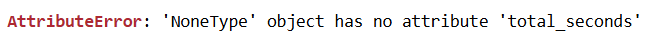

###### Hence why we do this:
###### Only needed for intraday data*

In [10]:
# Set date column as index
df = df.set_index('date')
#convert to EST timezone
df.index = df.index.tz_convert('US/Eastern')

AttributeError: 'Index' object has no attribute 'tz_convert'

In [74]:
#df.reset_index(inplace=True)

In [13]:
df.tail(3)

,open,high,low,close,volume,average,barCount
date,,,,,,,
2025-01-27,5998.25,6056.50,5996.75,6050.25,1688108.0,6028.825,581295
2025-01-28,6057.50,6105.50,6023.50,6091.25,1279360.0,6077.275,420786
2025-01-29,6087.50,6091.25,6042.25,6044.50,777836.0,6071.825,286548


In [17]:
df['close'].plot()

<AxesSubplot:xlabel='date'>

In [18]:
# Create Return and volatility column
df['Return'] = df['close'].pct_change()*100
df['Volatility'] = df['Return'].rolling(30).std()*np.sqrt(252)

In [19]:
# Extract hour and minute into a new column called 'time'
df['time'] = df.index.strftime('%H:%M')

AttributeError: 'Index' object has no attribute 'strftime'

In [35]:
df.head(3)

,open,high,low,close,volume,average,barCount,Return,Volatility,time
date,,,,,,,,,,
2024-07-12 09:40:00-04:00,5773.25,5773.25,5773.25,5773.25,1.0,5773.25,1,NaN,NaN,09:40
2024-07-12 09:45:00-04:00,5773.25,5773.25,5773.25,5773.25,0.0,5773.25,0,0.0,NaN,09:45
2024-07-12 09:50:00-04:00,5773.25,5773.25,5773.25,5773.25,0.0,5773.25,0,0.0,NaN,09:50


In [36]:
# Group by the time, and find the mean return. same for volatility
df1 = df.groupby('time')['Return'].mean()
df2 = df.groupby('time')['Volatility'].mean()

Text(0.5, 1.0, 'Mean Return by Time')

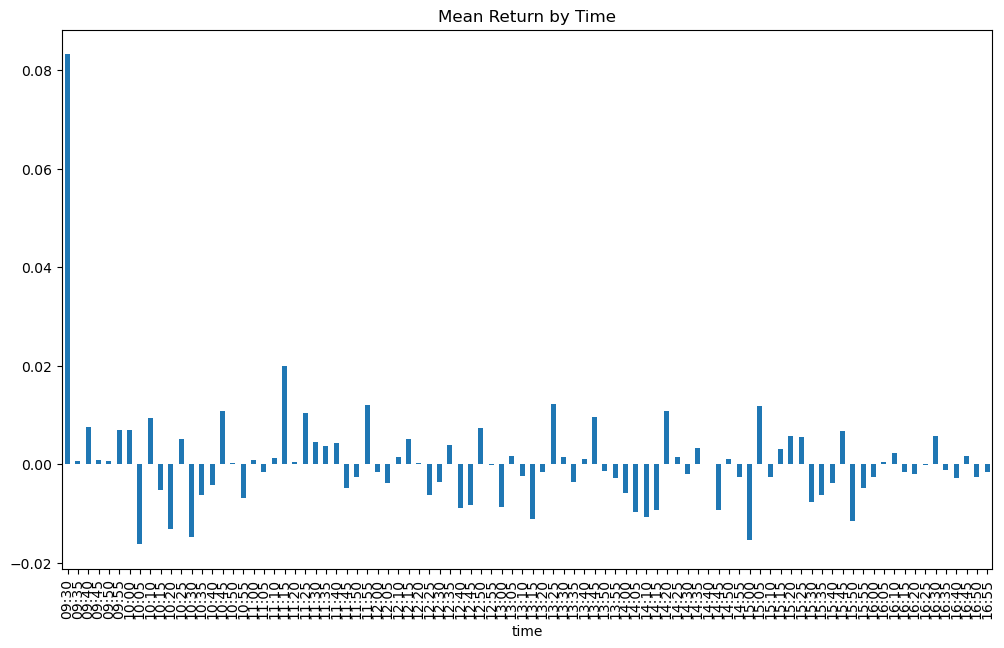

In [37]:
df1.plot(kind='bar', figsize=(12,7))
plt.title('Mean Return by Time')

Text(0.5, 1.0, 'Intraday Volatility')

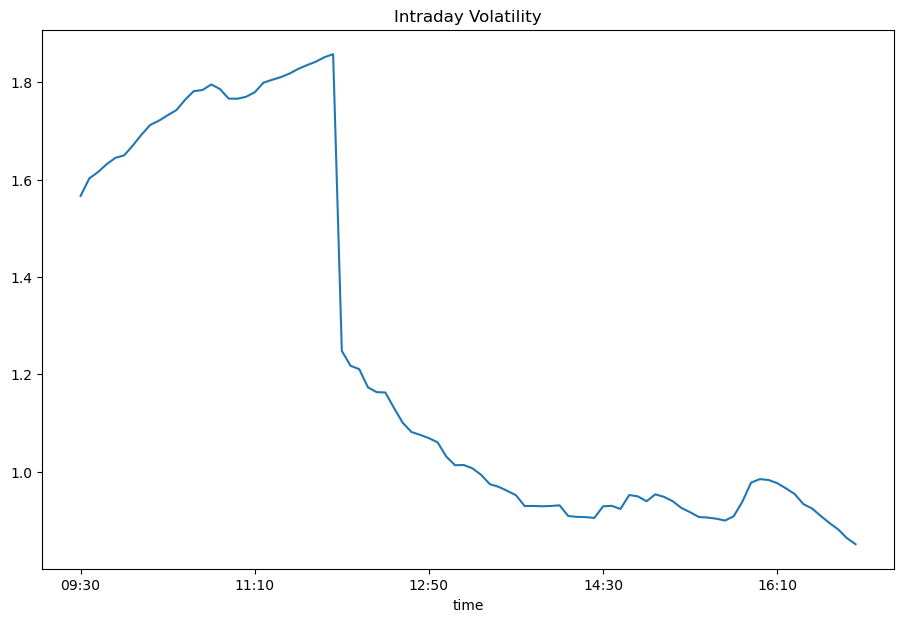

In [38]:
df2.plot(kind = "line", figsize = (11,7))
plt.title('Intraday Volatility')

Text(0.5, 1.0, 'Cumulative Return for 11:00-11:30')

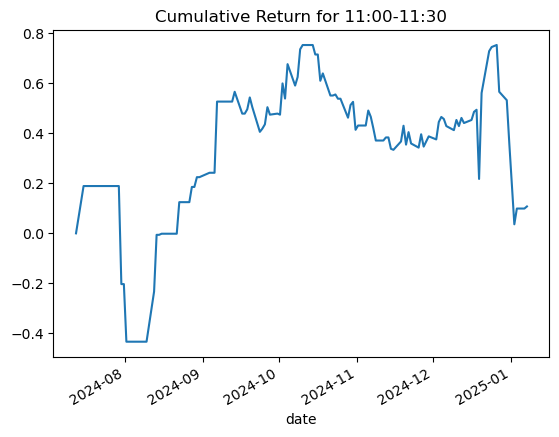

In [39]:
#Plot cumulative returns for specific time windows
df[df['time']=='11:00']['Return'].cumsum().plot()
plt.title('Cumulative Return for 11:00-11:30')

### Start bt Backtesting

The following image can be used as a base case for all backtests, this is a simple starting point which is a buy and hold strategy:

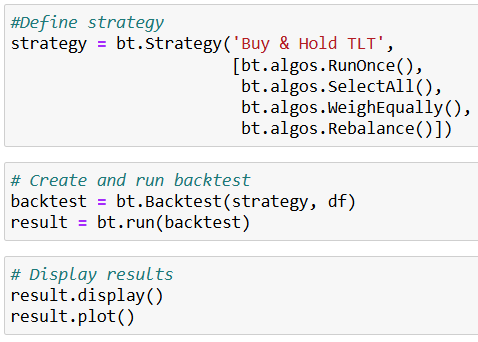

###### I start first with the logic or signal for the strategy, this is seperate from the actual bt code

In [14]:
# logic for identifying the last 5 trading days of each month
df['Last5Days'] = df.index.to_series().apply(
    lambda x: pd.Timestamp(x).is_month_end or 
              pd.Timestamp(x + pd.offsets.BDay(1)).is_month_end or 
              pd.Timestamp(x + pd.offsets.BDay(2)).is_month_end or 
              pd.Timestamp(x + pd.offsets.BDay(3)).is_month_end or 
              pd.Timestamp(x + pd.offsets.BDay(4)).is_month_end
)

In [15]:
# logic for identifying the first 5 trading days of the month (short signal)
df['First5Days'] = df.index.to_series().apply(
    lambda x: x.day <= 5
)

In [16]:
df['LongDays'] = df.index.to_series().apply(
    lambda x: x.day <= 5
)

In [17]:
# Create price dataframe with only closing price columns
price_data = df[['Close']] # make sure to use 2 square brackets idk why tho

In [18]:
# Prepare the signal DataFrame (align with Close column)
signal_df = pd.DataFrame(index=price_data.index, data={'Close': df['Last5Days']})
short_signal_df = pd.DataFrame(index=price_data.index, data={'Close': df['First5Days']})

###### Now begins the bt code for defining and running the backtest

In [19]:
# Define the strategy
strategy = bt.Strategy('Long ZN Last 5 Days of Month',
                       [bt.algos.RunDaily(),                   # Run logic daily
                        bt.algos.SelectWhere(signal_df),       # Use DataFrame with boolean variables (true/false) for signal
                        bt.algos.WeighEqually(),               # Allocate equally
                        bt.algos.Rebalance()])  

In [20]:
# Define the buy-and-hold strategy
buy_and_hold = bt.Strategy('ZN',
                           [bt.algos.RunOnce(),                   
                            bt.algos.SelectAll(),                 
                            bt.algos.WeighEqually(),            
                            bt.algos.Rebalance()]) 

In [21]:
# Create and run backtest
backtest = bt.Backtest(strategy, price_data) #bt requires a dataframe with just one column of prices to run (price_data)

# Create backtest for buy and hold
backtest_buy_and_hold = bt.Backtest(buy_and_hold, price_data)

In [22]:
# Run both backtests
result = bt.run(backtest, backtest_buy_and_hold)

Stat                 Long ZN Last 5 Days of Month    ZN
-------------------  ------------------------------  ----------
Start                2015-01-11                      2015-01-11
End                  2025-01-10                      2025-01-10
Risk-free rate       0.00%                           0.00%

Total Return         17.49%                          -16.74%
Daily Sharpe         0.75                            -0.31
Daily Sortino        1.29                            -0.51
CAGR                 1.63%                           -1.82%
Max Drawdown         -2.33%                          -24.87%
Calmar Ratio         0.70                            -0.07

MTD                  0.06%                           -1.19%
3m                   -0.79%                          -4.13%
6m                   0.81%                           -2.76%
YTD                  0.06%                           -1.19%
1Y                   4.09%                           -3.95%
3Y (ann.)            3.64%      

<AxesSubplot:title={'center':'Equity Progression'}>

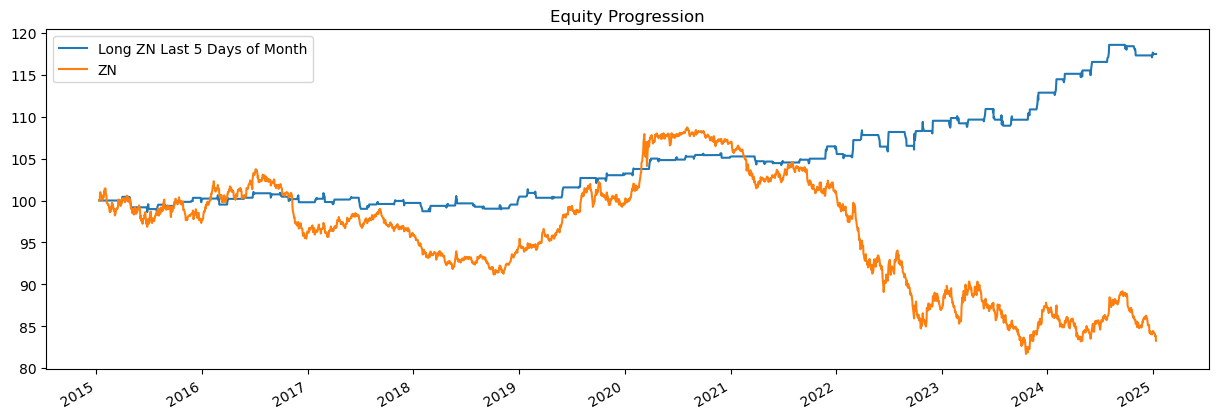

In [23]:
# Display results
result.display()
result.plot()